In [6]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
import tensorflow as tf
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [7]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/machine-learning-content/master/assets/spam.csv"
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df_raw.sample(10, random_state=2025)

,Category,Message
2349,ham,That seems unnecessarily affectionate
5397,ham,That's necessarily respectful
4028,ham,"Yes, princess. Are you going to make me moan?"
3165,ham,TODAY is Sorry day.! If ever i was angry with ...
2738,ham,Hi Chachi tried calling u now unable to reach ...
2504,ham,Fwiw the reason I'm only around when it's time...
378,ham,Well there's not a lot of things happening in ...
3799,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to..."
5138,ham,Yup... I havent been there before... You want ...
4086,spam,Orange brings you ringtones from all time Char...


In [9]:
df_baking = df_raw.copy()
df_baking = df_baking.drop_duplicates()
df_baking['spam or ham'] = (df_baking['Category'] == 'spam').astype(bool)
df_baking = df_baking.reset_index(drop=True)
df = df_baking.copy()
df


,Category,Message,spam or ham
0,ham,"Go until jurong point, crazy.. Available only ...",False
1,ham,Ok lar... Joking wif u oni...,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,ham,U dun say so early hor... U c already then say...,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False
...,...,...,...
5152,spam,This is the 2nd time we have tried 2 contact u...,True
5153,ham,Will ü b going to esplanade fr home?,False
5154,ham,"Pity, * was in mood for that. So...any other s...",False
5155,ham,The guy did some bitching but I acted like i'd...,False


In [10]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['Category'],
    random_state=2025
)
df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train['Category'],
    random_state=2025
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape


((3300, 3), (825, 3), (1032, 3))

In [11]:
df_train.describe().T

,count,unique,top,freq
Category,3300,2,ham,2890
Message,3300,3300,Aiyar dun disturb u liao... Thk u have lots 2 ...,1
spam or ham,3300,2,False,2890


In [12]:
(
    df_train['Message']
    .str.split(expand=True)
    .stack()
    .value_counts()[:20]
)

to      1270
you     1021
I        941
a        795
the      701
and      527
in       485
i        461
is       443
for      426
my       409
u        392
of       352
your     347
me       323
on       302
have     292
that     282
2        272
are      232
Name: count, dtype: int64

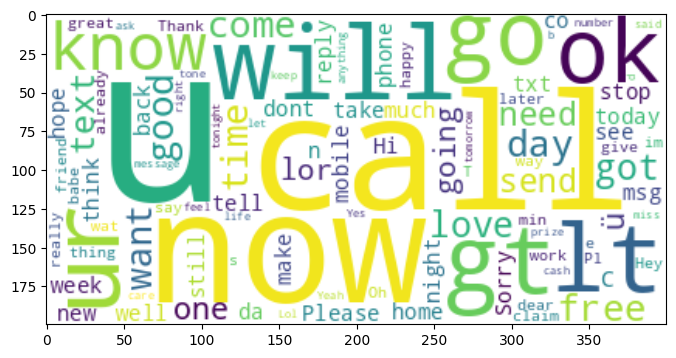

In [13]:
wordcloud = WordCloud(
    max_words=100,
    background_color='White',
    collocations=False
).generate(' '.join(df_train['Message']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()


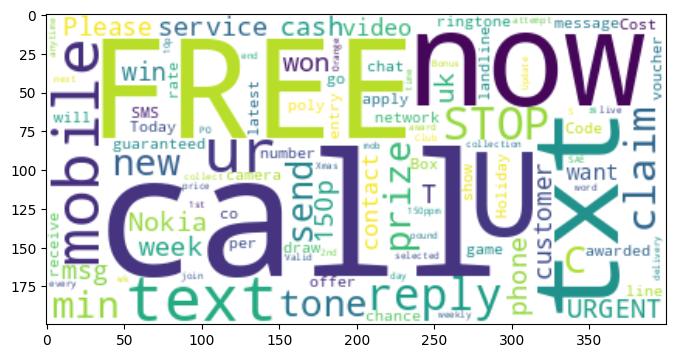

In [14]:
wordcloud = WordCloud(
    max_words=100,
    background_color='White',
    collocations=False
).generate(' '.join(df_train[df_train['spam or ham']]['Message']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()

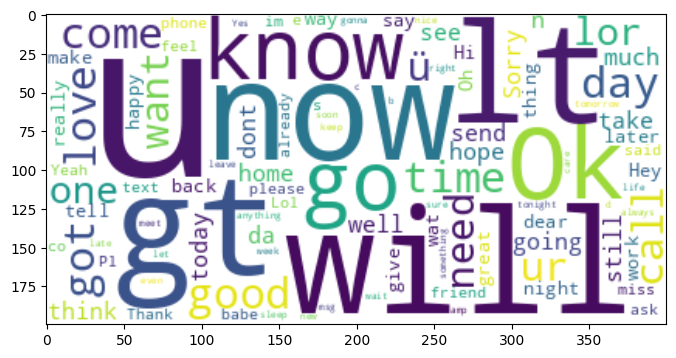

In [15]:
wordcloud = WordCloud(
    max_words=100,
    background_color='White',
    collocations=False
).generate(' '.join(df_train[~df_train['spam or ham']]['Message']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()

In [16]:
X_train = df_train['Message']
y_train = df_train['spam or ham']
X_val = df_val['Message']
y_val = df_val['spam or ham']
X_test = df_test['Message']
y_test = df_test['spam or ham']

In [17]:
vectorizer = TfidfVectorizer(max_features=3000,ngram_range=(1,2))
X_train_v = vectorizer.fit_transform(X_train).toarray()
X_val_v = vectorizer.transform(X_val).toarray()
X_test_v = vectorizer.transform(X_test).toarray()

In [18]:
X_train_v

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3300, 3000))

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256,activation='relu',input_shape=(X_train_v.shape[1],)),
    tf.keras.layers.Dense(128,activation='relu'),
    #tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

/workspaces/nlp_homework/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-05 00:12:43.726384: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       768,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801,281 (3.06 MB)

 Trainable params: 801,281 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [21]:
history = model.fit(
    X_train_v,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_v,y_val)
)

Epoch 1/50


2025-05-05 00:12:44.002043: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39600000 exceeds 10% of free system memory.


207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8787 - loss: 0.3366 - precision: 0.5441 - recall: 0.1540 - val_accuracy: 0.9867 - val_loss: 0.0400 - val_precision: 0.9423 - val_recall: 0.9515
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9949 - loss: 0.0247 - precision: 0.9862 - recall: 0.9707 - val_accuracy: 0.9903 - val_loss: 0.0367 - val_precision: 0.9612 - val_recall: 0.9612
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9986 - loss: 0.0063 - precision: 0.9994 - recall: 0.9884 - val_accuracy: 0.9879 - val_loss: 0.0438 - val_precision: 0.9429 - val_recall: 0.9612
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9996 - loss: 0.0027 - precision: 1.0000 - recall: 0.9965 - val_accuracy: 0.9891 - val_loss: 0.0490 - val_precision: 0.9519 - val_recall: 0.9612
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9989 - loss: 0.0039 - precision: 1.0000 - recall: 0.9912 - val_accuracy: 0.9891 - val_loss: 0.0553 - val_

In [22]:
model.evaluate(X_test_v,y_test)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9710 - loss: 0.2081 - precision: 0.8987 - recall: 0.8813


[0.14630863070487976, 0.979651153087616, 0.9212598204612732, 0.9140625]

[]

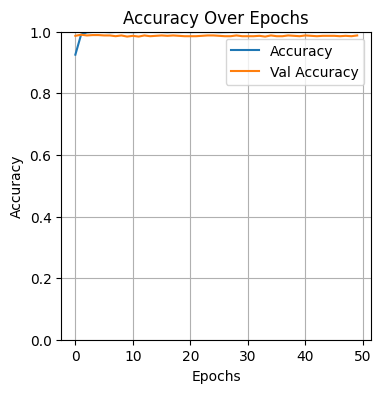

In [24]:
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()
plt.grid(True)
plt.plot()